# E-Commerce Fraud Detection

This project models E-Commerce transaction data to identify fraudelent activity, based on this [Kaggle Dataset](https://www.kaggle.com/datasets/umuttuygurr/e-commerce-fraud-detection-dataset). The dataset is synthetic, but very realistic, as it is modeled after real-life fraudulent activity observed in 2024, with scenarios such as
- Cards tested with $1 purchases at midnight
- Transactions that shipped “gaming accessories” 5,000 km away
- Promo codes being reused from freshly created accounts.

I decided to focus on this dataset as it is the most complete, realistic data on transaction fraud that I could find. Other fraud datasets that weren't synthetic had to obfuscate the meaning of features and their values for privacy reasons, using techniques like PCA, so features had meaningless names like V1, V2, etc.

Here is a list of the columns in the dataset with brief descriptions:

- `transaction_id`: Unique transaction identifier
- `user_id`: User identifier (each user 40–60 transactions)
- `account_age_days`: Age of user account in days
- `total_transactions_user`: Number of transactions per user
- `avg_amount_user`: User’s mean transaction amount
- `amount`: Transaction amount (USD)
- `country`: User’s country
- `bin_country`: Country of the card-issuing bank
- `channel`: “web” or “app”
- `merchant_category`: Type of purchase: electronics, fashion, grocery, gaming, travel
- `promo_used`: whether a discount/promo was used
- `avs_flag`: Address Verification result, a mismatch in the billing address provided by a customer and the one on file with their card issuer.
- `cvv_result`: CVV code match result, indicates if 3 digit code on back of card provided during an online transaction matched the card issuer's records
- `three_ds_flag`: 3D Secure enabled, so if a transaction is flagged, it prompts the customer to complete an extra verification step, such as a one-time code sent to your phone, a password, or biometric login
- `transaction_time`: Transaction timestamp (UTC)
- `shipping_distance_km`: Distance between billing and shipping addresses
- `is_fraud`: Target label (1 = fraud, 0 = normal)

## Setup
### Define parameters
The input/output parameters are defined in the next cell.

In [1]:
# Data input parameters
kaggle_source = "umuttuygurr/e-commerce-fraud-detection-dataset"
data_dir = "./data"
csv_file = "transactions.csv"
# Column definitions
target_col = "is_fraud"
id_cols = ['transaction_id', 'user_id']
date_feature = 'transaction_time'
# Define categorical features (including binary flags)
categorical_features = ['country', 'bin_country', 'channel', 'merchant_category', 
                       'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']
# Define numeric features (continuous/count variables only)
numeric_features = ['account_age_days', 'total_transactions_user', 'avg_amount_user', 
                   'amount', 'shipping_distance_km']
# Validation/Test split ratios
val_ratio = .2
test_ratio = .2

# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import pytz
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, roc_auc_score, f1_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

### Define functions

In [3]:
def download_data_csv(kaggle_source, data_dir, csv_file):
    """Download csv file from kaggle_source. Requires install of kaggle python
    package to use the Kaggle API and Kaggle API credentials set up in
    `~/.kaggle/kaggle.json`. Creates data directory, data_dir, if it doesn't
    exist. csv_file is the name of the downloaded file.
    """
    Path(data_dir).mkdir(parents=True, exist_ok=True)
    if not os.path.exists(f"{data_dir}/{csv_file}"):
        print(f"\nDownloading dataset from Kaggle...")
        !kaggle datasets download -d {kaggle_source} -p {data_dir} --unzip
        print("Download complete!")
    else:
        print(f"\nDataset already exists at {data_dir}/{csv_file}")

def load_data(data_dir, csv_file, verbose=True):
    df = pd.read_csv(
        f"{data_dir}/{csv_file}",
        low_memory=False  # Read entire file to infer dtypes properly
    )
    if verbose:
        print(f"\nDataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"\nMemory Usage:\n{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    return df
    
def plot_target_distribution(df, target_col):
    # Visualize target variable distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Count plot
    df[target_col].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('Target Variable Distribution (Count)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Is Fraud')
    axes[0].set_ylabel('Count')
    axes[0].set_xticklabels(['Normal (0)', 'Fraud (1)'], rotation=0)
    
    # Percentage plot
    df[target_col].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color=['skyblue', 'salmon'])
    axes[1].set_title('Target Variable Distribution (Percentage)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Is Fraud')
    axes[1].set_ylabel('Percentage')
    axes[1].set_xticklabels(['Normal (0)', 'Fraud (1)'], rotation=0)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    
    plt.tight_layout()
    plt.show()
    
def analyze_target_stats(df, target_col):
    # Target distribution
    target_dist = df[target_col].value_counts(normalize=True)
    print("\nTarget Distribution (%):")
    print(target_dist * 100)
    # Check class imbalance
    target_vals = target_dist.values
    target_ratio = target_vals[0] / target_vals[1]
    if target_ratio > 10:
        print(f"\n{BOLD}Warning: Large class imbalance ({target_ratio:.1f}) detected!\n")
    else:
        print(f"\nClass imbalance = {target_ratio:.1f}\n")
    plot_target_distribution(df, target_col)

def analyze_feature_stats(df, id_cols, target_col, categorical_features, numeric_features):
    # Summary for categorical/object columns
    print(f"\nCategorical Features ({len(categorical_features)}): {categorical_features}")
    if len(categorical_features) > 0:
        print("\nCategorical Features Summary:")
        for col in categorical_features:
            print(f"\n{col}:")
            print(f"  Unique values: {df[col].nunique()}")
            print(f"  Top 5 values:\n{df[col].value_counts().head()}")

    # Statistical summary for numerical columns
    print(f"\n\nNumeric Features ({len(numeric_features)}): {numeric_features}")
    print("\nNumeric Features Summary:")
    display(df[numeric_features].describe())
        
def split_train_val_test(df, val_ratio=.2, test_ratio=.2, stratify=None, r_seed=1, verbose=False):
    """Use the train_test_split function from sklearn to split input dataframe
    into randomly shuffled train, validation, and test datasets with the
    validation dataset containing val_ratio of the input data and the test
    dataset containing test_ratio of the input data. Stratify, if provided, is 
    the name of the column in df to use when stratifying the splits.
    """
    n = len(df)
    # Generate test dataset
    strat_col = stratify
    if stratify:
        strat_col = df[stratify]
    full_train_df, test_df = train_test_split(df, test_size=test_ratio, stratify=strat_col, random_state=r_seed)
    test_df = test_df.reset_index(drop=True)
    # Generate train, validation, and test splits
    val_ft_ratio = val_ratio / (1 - test_ratio)
    if stratify:
        strat_col = full_train_df[stratify]
    train_df, val_df = train_test_split(full_train_df, test_size=val_ft_ratio, stratify=strat_col, random_state=r_seed)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
        print(f"\nTrain set: {len(train_df)} rows ({len(train_df)/len(df)*100:.1f}%)")
        print(f"Validation set: {len(val_df)} rows ({len(val_df)/len(df)*100:.1f}%)")
        print(f"Test set: {len(test_df)} rows ({len(test_df)/len(df)*100:.1f}%)")
    return train_df, val_df, test_df

def calculate_mi_scores(df, categorical_features, target_col):
    """Calculate mutual information scores for categorical and ordinal features."""
    mi_scores = []
    for feature in categorical_features:
        score = mutual_info_score(df[feature], df[target_col])
        mi_scores.append({'feature': feature, 'mi_score': score})
    mi_df = pd.DataFrame(mi_scores).sort_values('mi_score', ascending=False).reset_index(drop=True)
    return mi_df

def calculate_numeric_correlations(df, numeric_features, target_col):
    """Calculate Pearson correlations for numeric features with target."""
    correlations = []
    for feature in numeric_features:
        corr = df[feature].corr(df[target_col])
        correlations.append({'feature': feature, 'correlation': corr, 'abs_correlation': abs(corr)})
    corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    return corr_df[['feature', 'correlation']]

def calculate_vif(df, numeric_features):
    """Calculate Variance Inflation Factor for numeric features."""
    X = df[numeric_features].values
    vif_data = []
    for i, feature in enumerate(numeric_features):
        vif = variance_inflation_factor(X, i)
        vif_data.append({'feature': feature, 'VIF': vif})
    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False).reset_index(drop=True)
    return vif_df

# ============ EDA FUNCTIONS ============

def plot_numeric_distributions(df, numeric_features):
    """Visualize distributions of numeric features with histograms."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_features):
        ax = axes[idx]
        df[col].hist(bins=50, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_title(f'Distribution of {col}', fontsize=11, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        
        mean_val = df[col].mean()
        median_val = df[col].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
        ax.legend()
    
    if len(numeric_features) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Observations:")
    print("- 'amount' and 'avg_amount_user' are right-skewed (consider log transformation)")
    print("- 'shipping_distance_km' shows wide variation (potential outliers)")
    print("- 'account_age_days' appears relatively uniform")
    print("- 'total_transactions_user' clusters around 50 transactions")

def analyze_vif(df, numeric_features):
    """Calculate and visualize VIF for multicollinearity detection."""
    vif_df = calculate_vif(df, numeric_features)
    print("Variance Inflation Factor (VIF) Analysis:")
    print("=" * 50)
    print(vif_df.to_string(index=False))
    print("\n" + "=" * 50)
    print("\nInterpretation:")
    print("- VIF < 5: Low multicollinearity (acceptable)")
    print("- VIF 5-10: Moderate multicollinearity (monitor)")
    print("- VIF > 10: High multicollinearity (consider removing)")
    
    plt.figure(figsize=(10, 5))
    plt.barh(vif_df['feature'], vif_df['VIF'], color='coral', edgecolor='black')
    plt.xlabel('VIF Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Variance Inflation Factor (VIF) - Multicollinearity Check', fontsize=13, fontweight='bold')
    plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF = 5 (Moderate)')
    plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF = 10 (High)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nKey Findings:")
    if vif_df['VIF'].max() > 10:
        high_vif = vif_df[vif_df['VIF'] > 10]['feature'].tolist()
        print(f"- High multicollinearity detected in: {high_vif}")
        print("- Consider removing or combining these features")
    elif vif_df['VIF'].max() > 5:
        print("- Moderate multicollinearity present but generally acceptable")
    else:
        print("- All features show low multicollinearity")
    
    return vif_df

def analyze_correlations(df, numeric_features, target_col):
    """Calculate and visualize correlations with target variable."""
    corr_df = calculate_numeric_correlations(df, numeric_features, target_col)
    print("Pearson Correlation with Target (is_fraud):")
    print("=" * 60)
    print(corr_df.to_string(index=False))
    print("=" * 60)
    
    plt.figure(figsize=(10, 5))
    colors = ['green' if x > 0 else 'red' for x in corr_df['correlation']]
    plt.barh(corr_df['feature'], corr_df['correlation'], color=colors, edgecolor='black')
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Correlation of Numeric Features with Fraud Target', fontsize=13, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights:")
    print("- Positive correlation: Higher values associated with fraud")
    print("- Negative correlation: Lower values associated with fraud")
    print("- Values closer to ±1 indicate stronger linear relationships")
    
    return corr_df

def plot_box_plots(df, numeric_features, target_col):
    """Compare feature distributions between fraud and non-fraud using box plots."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_features):
        ax = axes[idx]
        df.boxplot(column=col, by=target_col, ax=ax, patch_artist=True)
        ax.set_title(f'{col} by Fraud Status', fontsize=11, fontweight='bold')
        ax.set_xlabel('Is Fraud')
        ax.set_ylabel(col)
        ax.set_xticklabels(['Normal', 'Fraud'])
        plt.sca(ax)
        plt.xticks([1, 2], ['Normal (0)', 'Fraud (1)'])
    
    if len(numeric_features) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.suptitle('')
    plt.tight_layout()
    plt.show()
    
    print("\nBox Plot Interpretation:")
    print("- Look for differences in medians (center line) between fraud and non-fraud")
    print("- Different distributions suggest the feature is discriminative")
    print("- Overlapping boxes indicate less predictive power")

def analyze_temporal_patterns(df, date_feature, target_col, baseline_fraud_rate):
    """Analyze and visualize fraud patterns over time."""
    # Extract temporal features
    df['hour'] = df[date_feature].dt.hour
    df['day_of_week'] = df[date_feature].dt.dayofweek
    df['month'] = df[date_feature].dt.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Hour of day
    ax = axes[0, 0]
    hourly_fraud = df.groupby('hour')[target_col].mean()
    hourly_fraud.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate by Hour of Day', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Fraud Rate')
    ax.legend()
    
    # Day of week
    ax = axes[0, 1]
    dow_fraud = df.groupby('day_of_week')[target_col].mean()
    dow_fraud.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate by Day of Week', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day of Week (0=Monday, 6=Sunday)')
    ax.set_ylabel('Fraud Rate')
    ax.legend()
    
    # Month
    ax = axes[1, 0]
    monthly_fraud = df.groupby('month')[target_col].mean()
    monthly_fraud.plot(kind='bar', ax=ax, color='lightgreen', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate by Month', fontsize=12, fontweight='bold')
    ax.set_xlabel('Month')
    ax.set_ylabel('Fraud Rate')
    ax.legend()
    
    # Weekend vs Weekday
    ax = axes[1, 1]
    weekend_fraud = df.groupby('is_weekend')[target_col].mean()
    weekend_fraud.plot(kind='bar', ax=ax, color='orchid', edgecolor='black')
    ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, label='Baseline')
    ax.set_title('Fraud Rate: Weekday vs Weekend', fontsize=12, fontweight='bold')
    ax.set_xlabel('Is Weekend')
    ax.set_ylabel('Fraud Rate')
    ax.set_xticklabels(['Weekday (0)', 'Weekend (1)'], rotation=0)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nTemporal Insights:")
    print(f"- Peak fraud hour: {hourly_fraud.idxmax()} (fraud rate: {hourly_fraud.max():.4f})")
    print(f"- Safest hour: {hourly_fraud.idxmin()} (fraud rate: {hourly_fraud.min():.4f})")
    print(f"- Weekend fraud rate: {weekend_fraud[1]:.4f}")
    print(f"- Weekday fraud rate: {weekend_fraud[0]:.4f}")
    
    high_risk_hours = hourly_fraud[hourly_fraud > baseline_fraud_rate * 1.2]
    if not high_risk_hours.empty:
        print(f"\n⚠️  High-risk hours (>20% above baseline):")
        for hour, rate in high_risk_hours.items():
            print(f"   - Hour {hour}: {rate:.4f} fraud rate ({rate/baseline_fraud_rate:.1f}x baseline)")

def analyze_categorical_fraud_rates(df, categorical_features, target_col):
    """Analyze fraud rates for each categorical feature."""
    print("Fraud Rates by Categorical Features")
    print("=" * 80)
    
    for feature in categorical_features:
        print(f"\n{feature.upper()}:")
        print("-" * 80)
        
        fraud_rate = df.groupby(feature)[target_col].agg(['sum', 'count', 'mean']).reset_index()
        fraud_rate.columns = [feature, 'fraud_count', 'total_count', 'fraud_rate']
        fraud_rate['fraud_rate'] = fraud_rate['fraud_rate'] * 100
        fraud_rate = fraud_rate.sort_values('fraud_rate', ascending=False)
        
        print(fraud_rate.to_string(index=False))
        
        baseline_rate = df[target_col].mean() * 100
        high_risk = fraud_rate[fraud_rate['fraud_rate'] > baseline_rate * 1.5]
        if not high_risk.empty:
            print(f"\n⚠️  High-risk categories (>1.5x baseline rate of {baseline_rate:.2f}%):")
            for _, row in high_risk.iterrows():
                print(f"   - {row[feature]}: {row['fraud_rate']:.2f}% fraud rate")
    
    print("\n" + "=" * 80)

def plot_categorical_fraud_rates(df, categorical_features, target_col, baseline_fraud_rate):
    """Visualize fraud rates for categorical features."""
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    axes = axes.flatten()
    
    for idx, feature in enumerate(categorical_features):
        ax = axes[idx]
        fraud_rate = df.groupby(feature)[target_col].mean().sort_values(ascending=False)
        fraud_rate.plot(kind='bar', ax=ax, color='coral', edgecolor='black', alpha=0.8)
        ax.axhline(y=baseline_fraud_rate, color='red', linestyle='--', linewidth=2, 
                   label=f'Baseline: {baseline_fraud_rate:.3f}')
        ax.set_title(f'Fraud Rate by {feature}', fontsize=12, fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Fraud Rate')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization Insight:")
    print("- Categories significantly above the baseline (red line) are high-risk")
    print("- Large deviations suggest strong predictive power")

def analyze_mutual_information(df, categorical_features, target_col):
    """Calculate and visualize mutual information scores."""
    mi_df = calculate_mi_scores(df, categorical_features, target_col)
    print("\nMutual Information Scores (Categorical Features):")
    print("=" * 60)
    print(mi_df.to_string(index=False))
    print("=" * 60)
    print("\nInterpretation:")
    print("- Higher MI score = stronger association with target")
    print("- MI = 0 means no mutual dependence")
    print("- MI > 0.1 typically indicates meaningful predictive value")
    
    plt.figure(figsize=(10, 6))
    plt.barh(mi_df['feature'], mi_df['mi_score'], color='teal', edgecolor='black')
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Mutual Information: Categorical Features vs. Fraud Target', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return mi_df

def print_feature_recommendations(corr_df, mi_df, vif_df, numeric_features, categorical_features):
    """Print comprehensive feature selection recommendations."""
    print("=" * 80)
    print("FEATURE SELECTION RECOMMENDATIONS")
    print("=" * 80)
    
    print("\n📊 SUMMARY OF EDA FINDINGS:")
    print("-" * 80)
    
    print("\n1. NUMERIC FEATURES (Correlation Analysis):")
    print("   Features to KEEP (showing meaningful correlation):")
    for _, row in corr_df.head(5).iterrows():
        print(f"   ✓ {row['feature']}: {row['correlation']:.4f} correlation")
    
    print("\n2. CATEGORICAL FEATURES (Mutual Information Analysis):")
    print("   Features to KEEP (MI > 0.01):")
    high_mi_features = mi_df[mi_df['mi_score'] > 0.01]
    for _, row in high_mi_features.iterrows():
        print(f"   ✓ {row['feature']}: MI = {row['mi_score']:.4f}")
    
    print("\n3. MULTICOLLINEARITY CHECK:")
    if vif_df['VIF'].max() > 10:
        high_vif_features = vif_df[vif_df['VIF'] > 10]
        print("   ⚠️  Consider removing or combining these features:")
        for _, row in high_vif_features.iterrows():
            print(f"   - {row['feature']}: VIF = {row['VIF']:.2f}")
    else:
        print("   ✓ No severe multicollinearity detected")
    
    print("\n4. TEMPORAL PATTERNS:")
    print("   ✓ Hour of day shows fraud patterns (consider time-based features)")
    print("   ✓ Weekend/weekday distinction may be relevant")
    
    print("\n" + "=" * 80)
    print("RECOMMENDED FEATURES FOR MODELING:")
    print("=" * 80)
    
    print("\n✅ NUMERIC FEATURES (all 5):")
    for feat in numeric_features:
        print(f"   • {feat}")
    
    print("\n✅ CATEGORICAL FEATURES (all 8):")
    for feat in categorical_features:
        print(f"   • {feat}")
    
    print("\n✅ TEMPORAL FEATURES TO ENGINEER:")
    print("   • hour (from transaction_time)")
    print("   • day_of_week (from transaction_time)")
    print("   • is_weekend (derived from day_of_week)")
    print("   • is_midnight (hours 23-01)")
    
    print("\n💡 SUGGESTED FEATURE ENGINEERING:")
    print("   • country_mismatch: (country != bin_country)")
    print("   • amount_deviation: |amount - avg_amount_user|")
    print("   • amount_vs_avg_ratio: amount / avg_amount_user")
    print("   • high_risk_distance: (shipping_distance_km > threshold)")
    print("   • security_score: combination of avs_match + cvv_result + three_ds_flag")
    print("   • transaction_velocity: total_transactions_user / account_age_days")
    
    print("\n⚡ MODELING CONSIDERATIONS:")
    print("   • Use stratified sampling (class imbalance: 44:1)")
    print("   • Apply class weights or SMOTE for minority class")
    print("   • Use appropriate metrics: ROC-AUC, F1, Precision-Recall (not accuracy)")
    print("   • Consider threshold tuning for precision/recall trade-off")
    print("   • Try tree-based models (handle categorical features well)")
    
    print("\n" + "=" * 80)

### Define feature engineering functions

In [4]:
# ============ FEATURE ENGINEERING FUNCTIONS ============

def get_country_timezone_mapping():
    """Create mapping of country codes to capital city timezones."""
    return {
        'US': 'America/New_York',      # Washington D.C.
        'GB': 'Europe/London',          # London
        'FR': 'Europe/Paris',           # Paris
        'DE': 'Europe/Berlin',          # Berlin
        'IT': 'Europe/Rome',            # Rome
        'ES': 'Europe/Madrid',          # Madrid
        'NL': 'Europe/Amsterdam',       # Amsterdam
        'PL': 'Europe/Warsaw',          # Warsaw
        'RO': 'Europe/Bucharest',       # Bucharest
        'TR': 'Europe/Istanbul'         # Istanbul
    }

def convert_utc_to_local_time(df, date_col, country_col):
    """
    Convert UTC timestamps to local time based on country's capital timezone.
    Returns DataFrame with additional local_time column.

    Requires:
        - date_col must be timezone-aware datetime in UTC
        - Will raise ValueError if timezone is missing or not UTC
    """
    df = df.copy()
    tz_mapping = get_country_timezone_mapping()
    
    # Initialize local_time column (timezone-naive, will represent local times)
    df['local_time'] = df[date_col].dt.tz_localize(None)
    
    print("Converting UTC to local time by country...")
    for country, tz_str in tz_mapping.items():
        mask = df[country_col] == country
        if mask.sum() > 0:
            # Convert UTC to local timezone
            # Get the datetime series
            dt_series = df.loc[mask, date_col]

            # Validate that input is timezone-aware and in UTC
            if dt_series.dt.tz is None:
                raise ValueError(
                    f"Column '{date_col}' must be timezone-aware in UTC. "
                    f"Ensure timestamps are parsed with utc=True during data loading."
                )

            # Validate it's in UTC
            if str(dt_series.dt.tz) != 'UTC':
                raise ValueError(
                    f"Column '{date_col}' must be in UTC timezone, "
                    f"but found: {dt_series.dt.tz}"
                )

            # Convert UTC to target local timezone
            utc_times = dt_series
            local_times = utc_times.dt.tz_convert(tz_str).dt.tz_localize(None)
            df.loc[mask, 'local_time'] = local_times
    
    print(f"  ✓ Converted {len(df)} transactions to local time")
    return df

def create_temporal_features(df, date_col, use_local_time=False):
    """
    Create temporal features from timestamp column.
    If use_local_time=True, uses 'local_time' column instead of date_col.
    """
    df = df.copy()
    time_col = 'local_time' if use_local_time else date_col
    suffix = '_local' if use_local_time else ''
    
    # Extract basic time components
    df[f'hour{suffix}'] = df[time_col].dt.hour
    df[f'day_of_week{suffix}'] = df[time_col].dt.dayofweek  # 0=Monday, 6=Sunday
    df[f'month{suffix}'] = df[time_col].dt.month
    
    # Derived temporal features
    df[f'is_weekend{suffix}'] = (df[f'day_of_week{suffix}'] >= 5).astype(int)
    df[f'is_late_night{suffix}'] = ((df[f'hour{suffix}'] >= 23) | (df[f'hour{suffix}'] <= 4)).astype(int)
    df[f'is_business_hours{suffix}'] = ((df[f'hour{suffix}'] >= 9) & (df[f'hour{suffix}'] <= 17)).astype(int)
    
    features_created = [f'hour{suffix}', f'day_of_week{suffix}', f'month{suffix}',
                       f'is_weekend{suffix}', f'is_late_night{suffix}', f'is_business_hours{suffix}']
    
    return df, features_created

def create_amount_features(df):
    """Create transaction amount-based features."""
    df = df.copy()
    
    # Amount deviation from user's average
    df['amount_deviation'] = (df['amount'] - df['avg_amount_user']).abs()
    
    # Amount ratio compared to user's average (handle division by zero)
    df['amount_vs_avg_ratio'] = df['amount'] / df['avg_amount_user'].replace(0, 1)
    
    # Micro transactions (potential card testing)
    df['is_micro_transaction'] = (df['amount'] <= 5).astype(int)
    
    # Large transactions
    df['is_large_transaction'] = (df['amount'] >= df['amount'].quantile(0.95)).astype(int)
    
    features = ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']
    return df, features

def create_user_behavior_features(df):
    """Create user behavior-based features."""
    df = df.copy()
    
    # Transaction velocity (transactions per day of account age)
    df['transaction_velocity'] = df['total_transactions_user'] / df['account_age_days'].replace(0, 1)
    
    # New account flag (less than 30 days)
    df['is_new_account'] = (df['account_age_days'] <= 30).astype(int)
    
    # High frequency user
    df['is_high_frequency_user'] = (df['total_transactions_user'] >= df['total_transactions_user'].quantile(0.75)).astype(int)
    
    features = ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']
    return df, features

def create_geographic_features(df, risk_distance_quantile=0.75):
    """Create geographic-based features."""
    df = df.copy()
    
    # Country mismatch (user country != card issuing country)
    df['country_mismatch'] = (df['country'] != df['bin_country']).astype(int)
    
    # High risk shipping distance (>75th percentile)
    distance_threshold = df['shipping_distance_km'].quantile(risk_distance_quantile)
    df['high_risk_distance'] = (df['shipping_distance_km'] > distance_threshold).astype(int)
    
    # Zero distance (billing = shipping, lower risk)
    df['zero_distance'] = (df['shipping_distance_km'] == 0).astype(int)
    
    features = ['country_mismatch', 'high_risk_distance', 'zero_distance']
    return df, features

def create_security_features(df):
    """Create security verification-based features."""
    df = df.copy()
    
    # Security score (count of passed verifications)
    df['security_score'] = df['avs_match'] + df['cvv_result'] + df['three_ds_flag']
    
    # Count of failed verifications
    df['verification_failures'] = 3 - df['security_score']
    
    # All verifications passed
    df['all_verifications_passed'] = (df['security_score'] == 3).astype(int)
    
    # All verifications failed (high risk)
    df['all_verifications_failed'] = (df['security_score'] == 0).astype(int)
    
    features = ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']
    return df, features


def create_interaction_features(df):
    """Create interaction features for high-risk fraud pattern combinations."""
    df = df.copy()

    # SCENARIO 3: Promo codes from freshly created accounts
    # This is the classic promo abuse pattern
    df['new_account_with_promo'] = (df['is_new_account'] & (df['promo_used'] == 1)).astype(int)

    # SCENARIO 1: Card testing at unusual hours
    # Micro transactions at late night (local time)
    df['late_night_micro_transaction'] = (df['is_late_night_local'] & df['is_micro_transaction']).astype(int)

    # High-risk geographic + security combination
    # Country mismatch with verification failures
    df['foreign_card_failed_verification'] = (df['country_mismatch'] & (df['verification_failures'] > 0)).astype(int)

    # Suspicious velocity pattern
    # New account but already high frequency (account takeover or synthetic identity)
    df['new_high_velocity_account'] = (df['is_new_account'] & df['is_high_frequency_user']).astype(int)

    # High-risk distance + high amount (SCENARIO 2 variant)
    # Large transaction shipped very far
    df['high_value_long_distance'] = (df['is_large_transaction'] & df['high_risk_distance']).astype(int)

    # Triple threat: new account + promo + failed verification
    df['triple_risk_combo'] = ((df['is_new_account'] == 1) &
                               (df['promo_used'] == 1) &
                               (df['verification_failures'] > 0)).astype(int)

    features = ['new_account_with_promo', 'late_night_micro_transaction',
                'foreign_card_failed_verification', 'new_high_velocity_account',
                'high_value_long_distance', 'triple_risk_combo']
    return df, features


def engineer_features(df, date_col='transaction_time', country_col='country'):
    """
    Master function to create all engineered features.
    Includes both UTC and local time-based features.
    """
    print("=" * 80)
    print("FEATURE ENGINEERING")
    print("=" * 80)
    
    df_eng = df.copy()
    all_new_features = []
    
    # 1. Convert to local time
    print("\n1. TIMEZONE CONVERSION:")
    df_eng = convert_utc_to_local_time(df_eng, date_col, country_col)
    
    # 2. Temporal features (UTC)
    print("\n2. TEMPORAL FEATURES (UTC):")
    df_eng, utc_features = create_temporal_features(df_eng, date_col, use_local_time=False)
    print(f"  ✓ Created {len(utc_features)} UTC temporal features")
    all_new_features.extend(utc_features)
    
    # 3. Temporal features (Local time)
    print("\n3. TEMPORAL FEATURES (LOCAL TIME):")
    df_eng, local_features = create_temporal_features(df_eng, date_col, use_local_time=True)
    print(f"  ✓ Created {len(local_features)} local time temporal features")
    all_new_features.extend(local_features)
    
    # 4. Amount features
    print("\n4. TRANSACTION AMOUNT FEATURES:")
    df_eng, amount_features = create_amount_features(df_eng)
    print(f"  ✓ Created {len(amount_features)} amount-based features: {amount_features}")
    all_new_features.extend(amount_features)
    
    # 5. User behavior features
    print("\n5. USER BEHAVIOR FEATURES:")
    df_eng, behavior_features = create_user_behavior_features(df_eng)
    print(f"  ✓ Created {len(behavior_features)} behavior features: {behavior_features}")
    all_new_features.extend(behavior_features)
    
    # 6. Geographic features
    print("\n6. GEOGRAPHIC FEATURES:")
    df_eng, geo_features = create_geographic_features(df_eng)
    print(f"  ✓ Created {len(geo_features)} geographic features: {geo_features}")
    all_new_features.extend(geo_features)
    
    # 7. Security features
    print("\n7. SECURITY FEATURES:")
    df_eng, security_features = create_security_features(df_eng)
    print(f"  ✓ Created {len(security_features)} security features: {security_features}")
    all_new_features.extend(security_features)
    
    # 8. Interaction features
    print("\n8. INTERACTION FEATURES (High-Risk Combinations):")
    df_eng, interaction_features = create_interaction_features(df_eng)
    print(f"  ✓ Created {len(interaction_features)} interaction features: {interaction_features}")
    all_new_features.extend(interaction_features)

    # Summary
    print("\n" + "=" * 80)
    print(f"FEATURE ENGINEERING COMPLETE")
    print(f"Total new features created: {len(all_new_features)}")
    print(f"Original shape: {df.shape}")
    print(f"New shape: {df_eng.shape}")
    print("=" * 80)
    
    return df_eng, all_new_features

def analyze_final_feature_selection(train_new_features):
    """
    Comprehensive final feature selection analysis based on EDA insights
    and engineered features. Returns categorized feature recommendations.
    """
    print("=" * 80)
    print("FINAL FEATURE SELECTION FOR MODELING")
    print("=" * 80)

    # Define all available features
    original_numeric = ['account_age_days', 'total_transactions_user', 'avg_amount_user',
                       'amount', 'shipping_distance_km']
    original_categorical = ['country', 'bin_country', 'channel', 'merchant_category',
                           'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']

    print("\n📊 AVAILABLE FEATURES:")
    print("-" * 80)
    print(f"Original features: {len(original_numeric) + len(original_categorical)}")
    print(f"  • Numeric: {len(original_numeric)}")
    print(f"  • Categorical: {len(original_categorical)}")
    print(f"Engineered features: {len(train_new_features)}")
    print(f"Total available: {len(original_numeric) + len(original_categorical) + len(train_new_features)}")

    # Categorize engineered features
    temporal_utc = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_late_night', 'is_business_hours']
    temporal_local = ['hour_local', 'day_of_week_local', 'month_local', 'is_weekend_local',
                     'is_late_night_local', 'is_business_hours_local']
    amount_features = ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']
    behavior_features = ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']
    geographic_features = ['country_mismatch', 'high_risk_distance', 'zero_distance']
    security_features = ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']
    interaction_features = ['new_account_with_promo', 'late_night_micro_transaction',
                           'foreign_card_failed_verification', 'new_high_velocity_account',
                           'high_value_long_distance', 'triple_risk_combo']

    print("\n🔍 FEATURE SELECTION ANALYSIS:")
    print("-" * 80)

    # 1. Original Features - Keep high-value ones
    print("\n1. ORIGINAL FEATURES:")
    print("   ✅ KEEP ALL NUMERIC (5):")
    print("      • shipping_distance_km - Strong correlation (0.27)")
    print("      • amount - Moderate correlation (0.20)")
    print("      • account_age_days - Negative correlation (-0.12)")
    print("      • total_transactions_user, avg_amount_user - Baseline info")

    print("\n   ✅ KEEP HIGH-VALUE CATEGORICAL (5 of 8):")
    print("      • avs_match - High MI (0.017), 9.8% fraud when failed")
    print("      • cvv_result - High MI (0.015), 10.6% fraud when failed")
    print("      • three_ds_flag - High MI (0.010), 6.7% fraud when disabled")
    print("      • channel - High signal (3.6% fraud on web vs 0.8% on app)")
    print("      • promo_used - High signal (4.6% fraud when used)")

    print("\n   ⚠️  EXCLUDE (3 of 8) - Redundant with engineered features:")
    print("      • country → Replaced by country_mismatch (more specific)")
    print("      • bin_country → Replaced by country_mismatch")
    print("      • merchant_category → Low signal, all categories near baseline")

    # 2. Temporal Features - Choose local over UTC
    print("\n2. TEMPORAL FEATURES:")
    print("   ✅ KEEP LOCAL TIME FEATURES (6):")
    print("      • hour_local - Better captures 'unusual hour' fraud")
    print("      • is_late_night_local - Fraud scenario #1 (midnight transactions)")
    print("      • is_weekend_local, day_of_week_local, month_local")
    print("      • is_business_hours_local - Inverse of late_night signal")

    print("\n   ⚠️  EXCLUDE UTC FEATURES (6) - Redundant:")
    print("      • Local time is more meaningful for fraud detection")
    print("      • UTC features don't align with human behavior patterns")

    # 3. Amount Features - Keep all
    print("\n3. AMOUNT FEATURES:")
    print("   ✅ KEEP ALL (4):")
    print("      • is_micro_transaction - Fraud scenario #1 ($1 card testing)")
    print("      • amount_vs_avg_ratio - User deviation signal")
    print("      • is_large_transaction - High-value fraud attempts")
    print("      • amount_deviation - Absolute deviation signal")

    # 4. Behavior Features - Keep all
    print("\n4. USER BEHAVIOR FEATURES:")
    print("   ✅ KEEP ALL (3):")
    print("      • is_new_account - Fraud scenario #3 (fresh accounts)")
    print("      • transaction_velocity - Rapid account usage")
    print("      • is_high_frequency_user - Baseline comparison")

    # 5. Geographic Features - Keep all
    print("\n5. GEOGRAPHIC FEATURES:")
    print("   ✅ KEEP ALL (3):")
    print("      • country_mismatch - Replaces country + bin_country")
    print("      • high_risk_distance - Fraud scenario #2 (5000km shipments)")
    print("      • zero_distance - Low-risk indicator")

    # 6. Security Features - Keep composite score only
    print("\n6. SECURITY FEATURES:")
    print("   ✅ KEEP COMPOSITE SCORE (1 of 4):")
    print("      • security_score - Replaces individual avs/cvv/3ds flags")

    print("\n   ⚠️  EXCLUDE (3 of 4) - Redundant:")
    print("      • verification_failures → Inverse of security_score")
    print("      • all_verifications_passed → Encoded in security_score == 3")
    print("      • all_verifications_failed → Encoded in security_score == 0")
    print("      Note: Keep original avs_match, cvv_result, three_ds_flag for interpretability")

    # 7. Interaction Features - Keep scenario-specific only
    print("\n7. INTERACTION FEATURES:")
    print("   ✅ KEEP SCENARIO-SPECIFIC (3 of 6):")
    print("      • new_account_with_promo - Fraud scenario #3 (explicit)")
    print("      • late_night_micro_transaction - Fraud scenario #1 (explicit)")
    print("      • high_value_long_distance - Fraud scenario #2 variant")

    print("\n   ⚠️  EXCLUDE COMPOSITE INTERACTIONS (3 of 6):")
    print("      • foreign_card_failed_verification → Covered by country_mismatch + security_score")
    print("      • new_high_velocity_account → Covered by is_new_account + is_high_frequency_user")
    print("      • triple_risk_combo → Overly specific, low frequency")

    # Final recommendations
    print("\n" + "=" * 80)
    print("FINAL FEATURE SET FOR MODELING")
    print("=" * 80)

    # Build final feature lists
    final_numeric = original_numeric.copy()
    final_categorical = ['channel', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']
    final_temporal = temporal_local.copy()
    final_amount = amount_features.copy()
    final_behavior = behavior_features.copy()
    final_geographic = geographic_features.copy()
    final_security = ['security_score']
    final_interaction = ['new_account_with_promo', 'late_night_micro_transaction', 'high_value_long_distance']

    all_final_features = (final_numeric + final_categorical + final_temporal +
                         final_amount + final_behavior + final_geographic +
                         final_security + final_interaction)

    print(f"\nTotal features selected: {len(all_final_features)} (from {len(original_numeric) + len(original_categorical) + len(train_new_features)} available)")
    print(f"Reduction: {len(original_numeric) + len(original_categorical) + len(train_new_features) - len(all_final_features)} features excluded")

    print("\n📋 FINAL FEATURE LIST BY CATEGORY:")
    print("-" * 80)

    print(f"\n1. Original Numeric ({len(final_numeric)}):")
    for feat in final_numeric:
        print(f"   • {feat}")

    print(f"\n2. Original Categorical ({len(final_categorical)}):")
    for feat in final_categorical:
        print(f"   • {feat}")

    print(f"\n3. Temporal (Local Time) ({len(final_temporal)}):")
    for feat in final_temporal:
        print(f"   • {feat}")

    print(f"\n4. Amount Features ({len(final_amount)}):")
    for feat in final_amount:
        print(f"   • {feat}")

    print(f"\n5. User Behavior ({len(final_behavior)}):")
    for feat in final_behavior:
        print(f"   • {feat}")

    print(f"\n6. Geographic ({len(final_geographic)}):")
    for feat in final_geographic:
        print(f"   • {feat}")

    print(f"\n7. Security ({len(final_security)}):")
    for feat in final_security:
        print(f"   • {feat}")

    print(f"\n8. Interaction (Fraud Scenarios) ({len(final_interaction)}):")
    for feat in final_interaction:
        print(f"   • {feat}")

    print("\n" + "=" * 80)
    print("KEY DECISIONS:")
    print("=" * 80)
    print("✓ Local time > UTC time (better fraud signal)")
    print("✓ country_mismatch > individual country fields (more specific)")
    print("✓ security_score composite > individual flags (reduces dimensionality)")
    print("✓ Kept original avs/cvv/3ds for interpretability despite redundancy")
    print("✓ Scenario-specific interactions > generic combinations")
    print("✓ Excluded merchant_category (low predictive value)")

    print("\n" + "=" * 80)

    return {
        'numeric': final_numeric,
        'categorical': final_categorical,
        'temporal': final_temporal,
        'amount': final_amount,
        'behavior': final_behavior,
        'geographic': final_geographic,
        'security': final_security,
        'interaction': final_interaction,
        'all_features': all_final_features
    }


## Load data

In [5]:
download_data_csv(kaggle_source, data_dir, csv_file)
input_df = load_data(data_dir, csv_file, verbose=True)


Dataset already exists at ./data/transactions.csv

Dataset Shape: 299695 rows, 17 columns

Memory Usage:
107.29 MB


In [6]:
input_df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [7]:
# No null values
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

## Preprocessing
### Verify table grain

In [8]:
print(f"Every row is uniquely defined by transaction and user id columns: {len(input_df)==len(input_df.drop_duplicates(subset=id_cols))}")

Every row is uniquely defined by transaction and user id columns: True


### Target class balance
Target class imbalance is investigated prior to train/validation/test split because stratified splitting is necessary to handle the large class imbalance present in this dataset (only 2.2% fraud). Modeling will require techniques such as stratified sampling, class weights, appropriate metrics, etc.


Target Distribution (%):
is_fraud
0    97.793757
1     2.206243
Name: proportion, dtype: float64




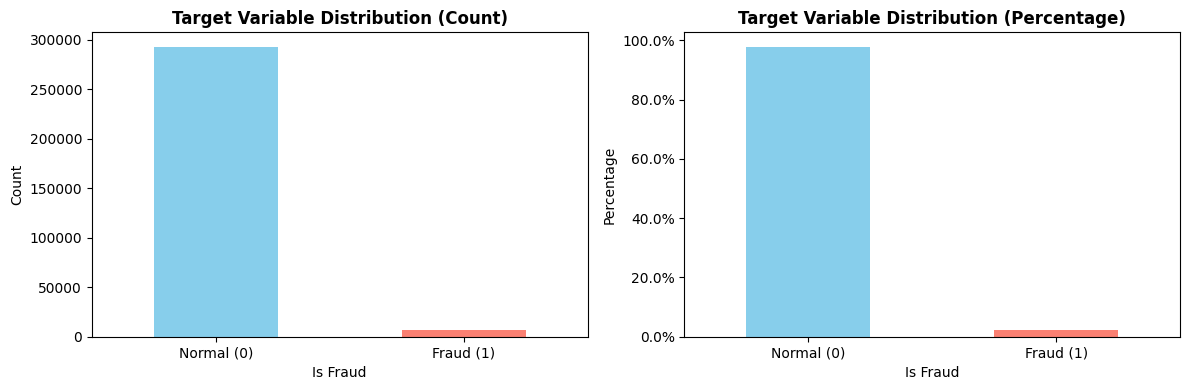

In [9]:
analyze_target_stats(input_df, target_col)

### Convert date type

In [10]:
# Parse timestamps as UTC timezone-aware (fail if timezone missing)
input_df[date_feature] = pd.to_datetime(input_df[date_feature], utc=True, errors='coerce')

### Feature stats
Examine the distribution of categorical features and compute summary statistics for numerical features. Binary features (0/1 flags) are treated as categorical since they represent discrete states (see Setup, Define parameters section above).

In [11]:
analyze_feature_stats(input_df, id_cols, target_col, categorical_features, numeric_features)


Categorical Features (8): ['country', 'bin_country', 'channel', 'merchant_category', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag']

Categorical Features Summary:

country:
  Unique values: 10
  Top 5 values:
country
US    32430
GB    30602
FR    30343
NL    30220
TR    30074
Name: count, dtype: int64

bin_country:
  Unique values: 10
  Top 5 values:
bin_country
US    32295
GB    30563
FR    30261
NL    30256
TR    29972
Name: count, dtype: int64

channel:
  Unique values: 2
  Top 5 values:
channel
web    152226
app    147469
Name: count, dtype: int64

merchant_category:
  Unique values: 5
  Top 5 values:
merchant_category
electronics    60220
travel         59922
grocery        59913
gaming         59839
fashion        59801
Name: count, dtype: int64

promo_used:
  Unique values: 2
  Top 5 values:
promo_used
0    253650
1     46045
Name: count, dtype: int64

avs_match:
  Unique values: 2
  Top 5 values:
avs_match
1    251144
0     48551
Name: count, dtype: int64

cvv_resul

,account_age_days,total_transactions_user,avg_amount_user,amount,shipping_distance_km
count,299695.000000,299695.000000,299695.000000,299695.000000,299695.000000
mean,973.397871,50.673321,148.142973,177.165279,357.049028
std,525.241409,5.976391,200.364624,306.926507,427.672074
min,1.000000,40.000000,3.520000,1.000000,0.000000
25%,516.000000,46.000000,46.190000,42.100000,136.600000
50%,975.000000,51.000000,90.130000,89.990000,273.020000
75%,1425.000000,56.000000,173.450000,191.110000,409.180000
max,1890.000000,60.000000,4565.290000,16994.740000,3748.560000


### Train/Validation/Test Splits

In [12]:
train_df, val_df, test_df = split_train_val_test(input_df, val_ratio=val_ratio, test_ratio=test_ratio, stratify=target_col, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True

Train set: 179817 rows (60.0%)
Validation set: 59939 rows (20.0%)
Test set: 59939 rows (20.0%)


## EDA
### Numeric features
#### Calculate baseline metrics
Define baseline fraud rate for comparison throughout EDA.

In [13]:
# Calculate baseline fraud rate from training set
baseline_fraud_rate = train_df[target_col].mean()
print(f"Baseline fraud rate: {baseline_fraud_rate:.4f} ({baseline_fraud_rate*100:.2f}%)")
print(f"This will be used as a reference point throughout the EDA.")

Baseline fraud rate: 0.0221 (2.21%)
This will be used as a reference point throughout the EDA.


#### Visualize distributions of numeric features

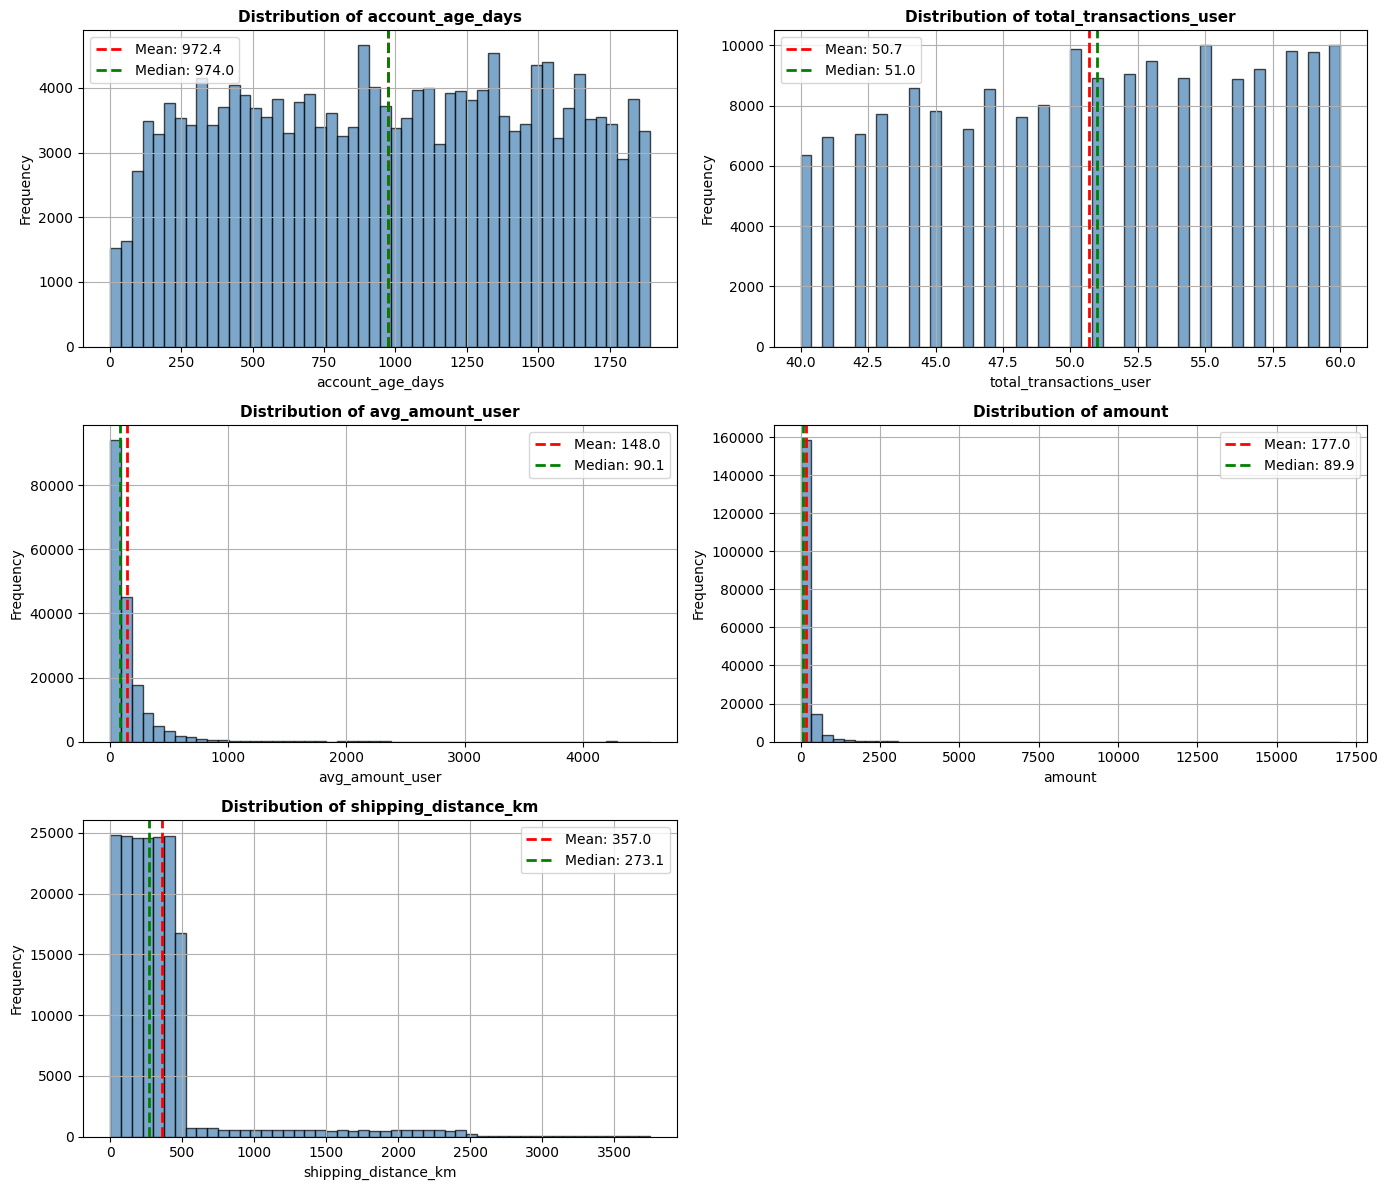


Key Observations:
- 'amount' and 'avg_amount_user' are right-skewed (consider log transformation)
- 'shipping_distance_km' shows wide variation (potential outliers)
- 'account_age_days' appears relatively uniform
- 'total_transactions_user' clusters around 50 transactions


In [14]:
plot_numeric_distributions(train_df, numeric_features)

#### Multicollinearity Detection (VIF)

Variance Inflation Factor (VIF) Analysis:
                feature      VIF
total_transactions_user 5.358876
       account_age_days 4.172834
        avg_amount_user 3.336393
                 amount 2.884962
   shipping_distance_km 1.689913


Interpretation:
- VIF < 5: Low multicollinearity (acceptable)
- VIF 5-10: Moderate multicollinearity (monitor)
- VIF > 10: High multicollinearity (consider removing)


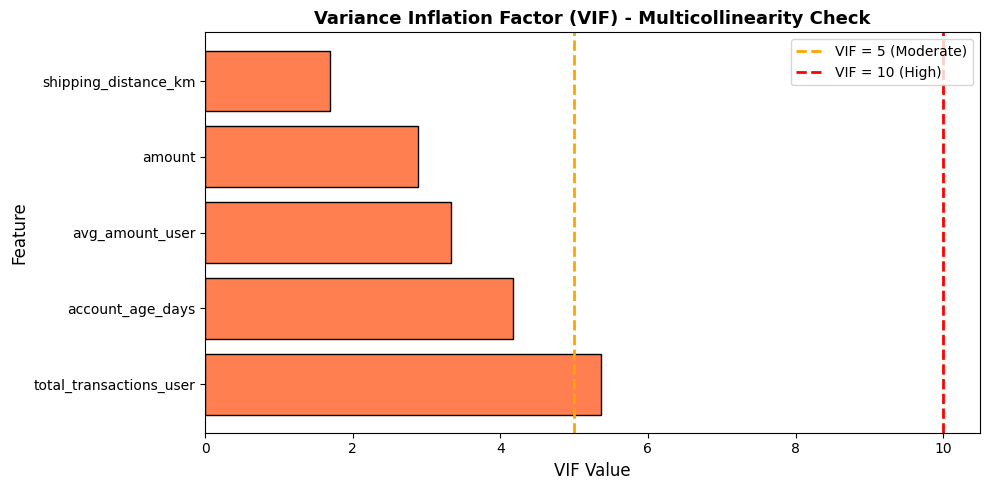


Key Findings:
- Moderate multicollinearity present but generally acceptable


In [15]:
vif_df = analyze_vif(train_df, numeric_features)

### Bivariate Analysis: Features vs. Target
#### Calculate correlations with target

Pearson Correlation with Target (is_fraud):
                feature  correlation
   shipping_distance_km     0.268378
                 amount     0.199198
       account_age_days    -0.121475
total_transactions_user    -0.012988
        avg_amount_user    -0.001313


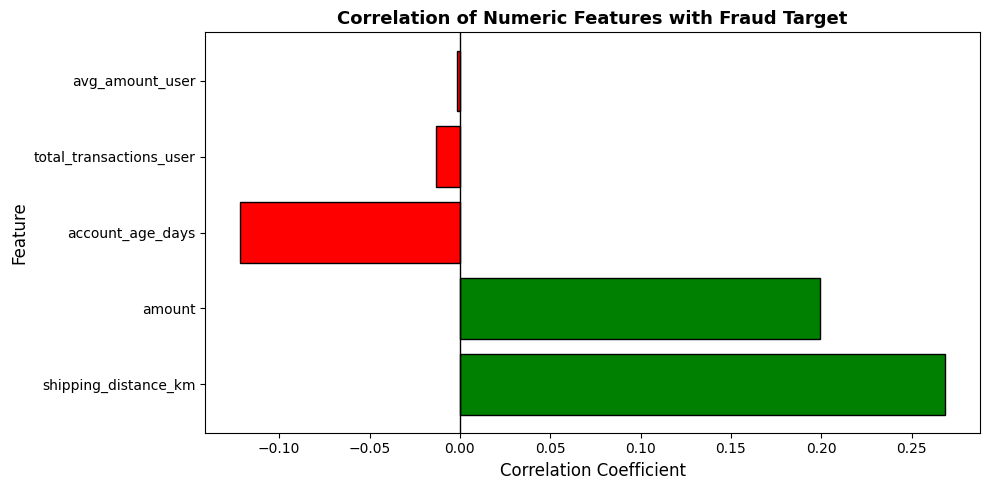


Key Insights:
- Positive correlation: Higher values associated with fraud
- Negative correlation: Lower values associated with fraud
- Values closer to ±1 indicate stronger linear relationships


In [16]:
corr_df = analyze_correlations(train_df, numeric_features, target_col)

#### Box plots: Compare feature distributions between fraud and non-fraud

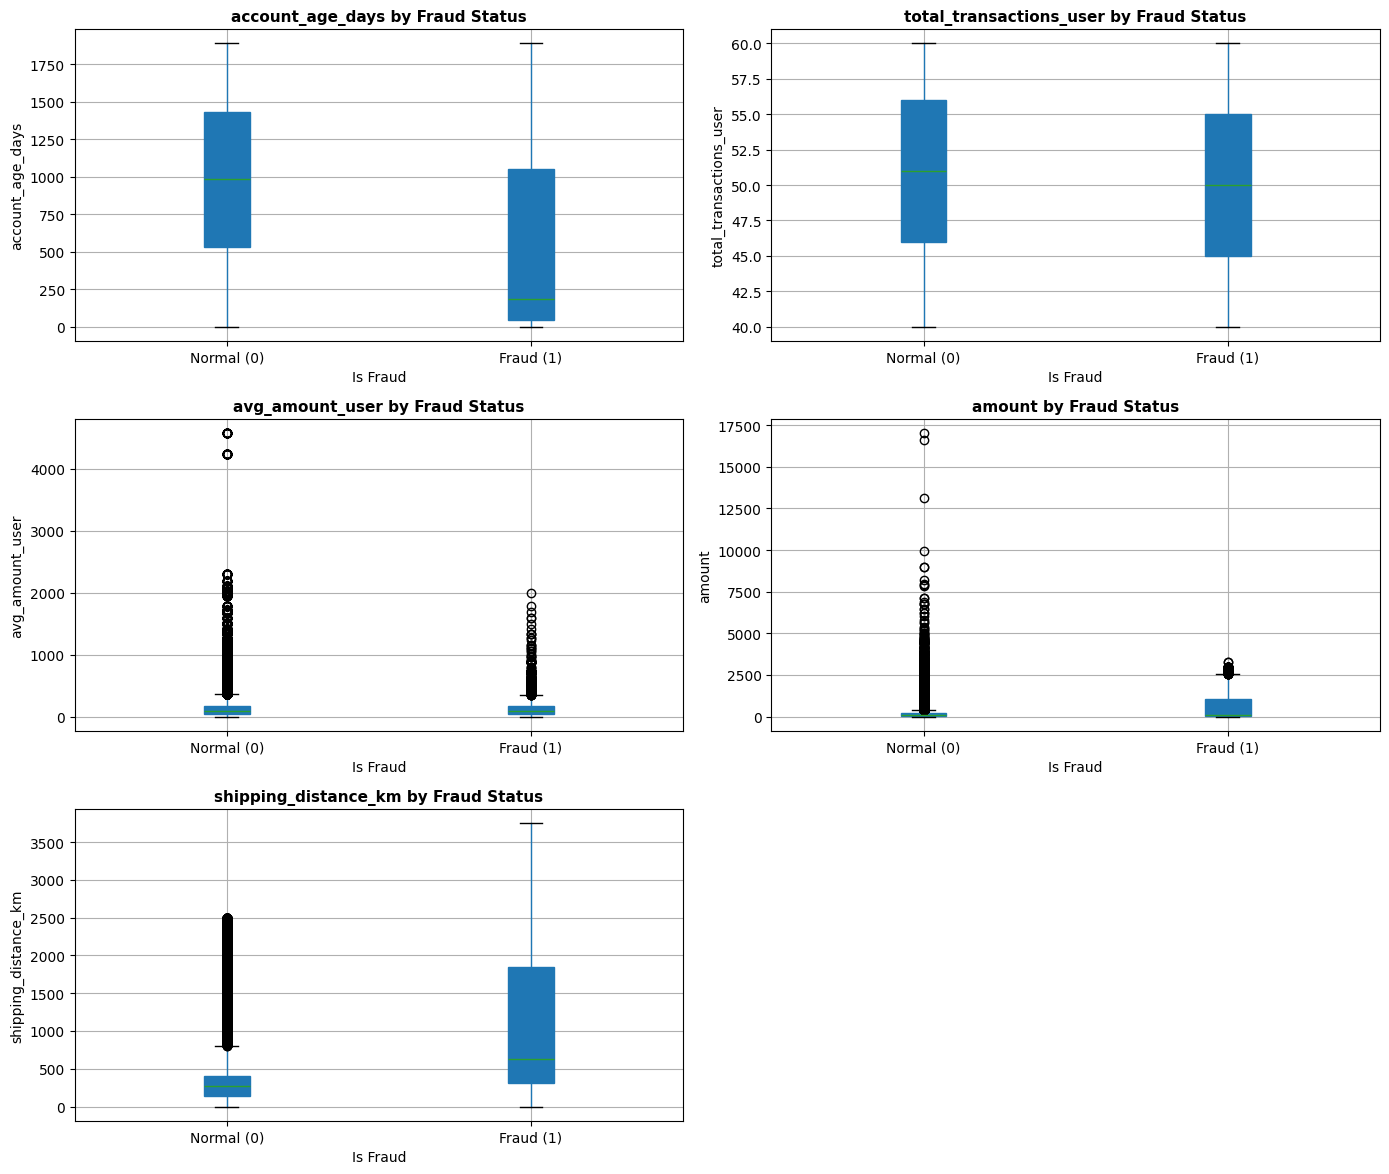


Box Plot Interpretation:
- Look for differences in medians (center line) between fraud and non-fraud
- Different distributions suggest the feature is discriminative
- Overlapping boxes indicate less predictive power


In [17]:
plot_box_plots(train_df, numeric_features, target_col)

### Temporal Analysis
Analyze fraud patterns over time to identify temporal trends.

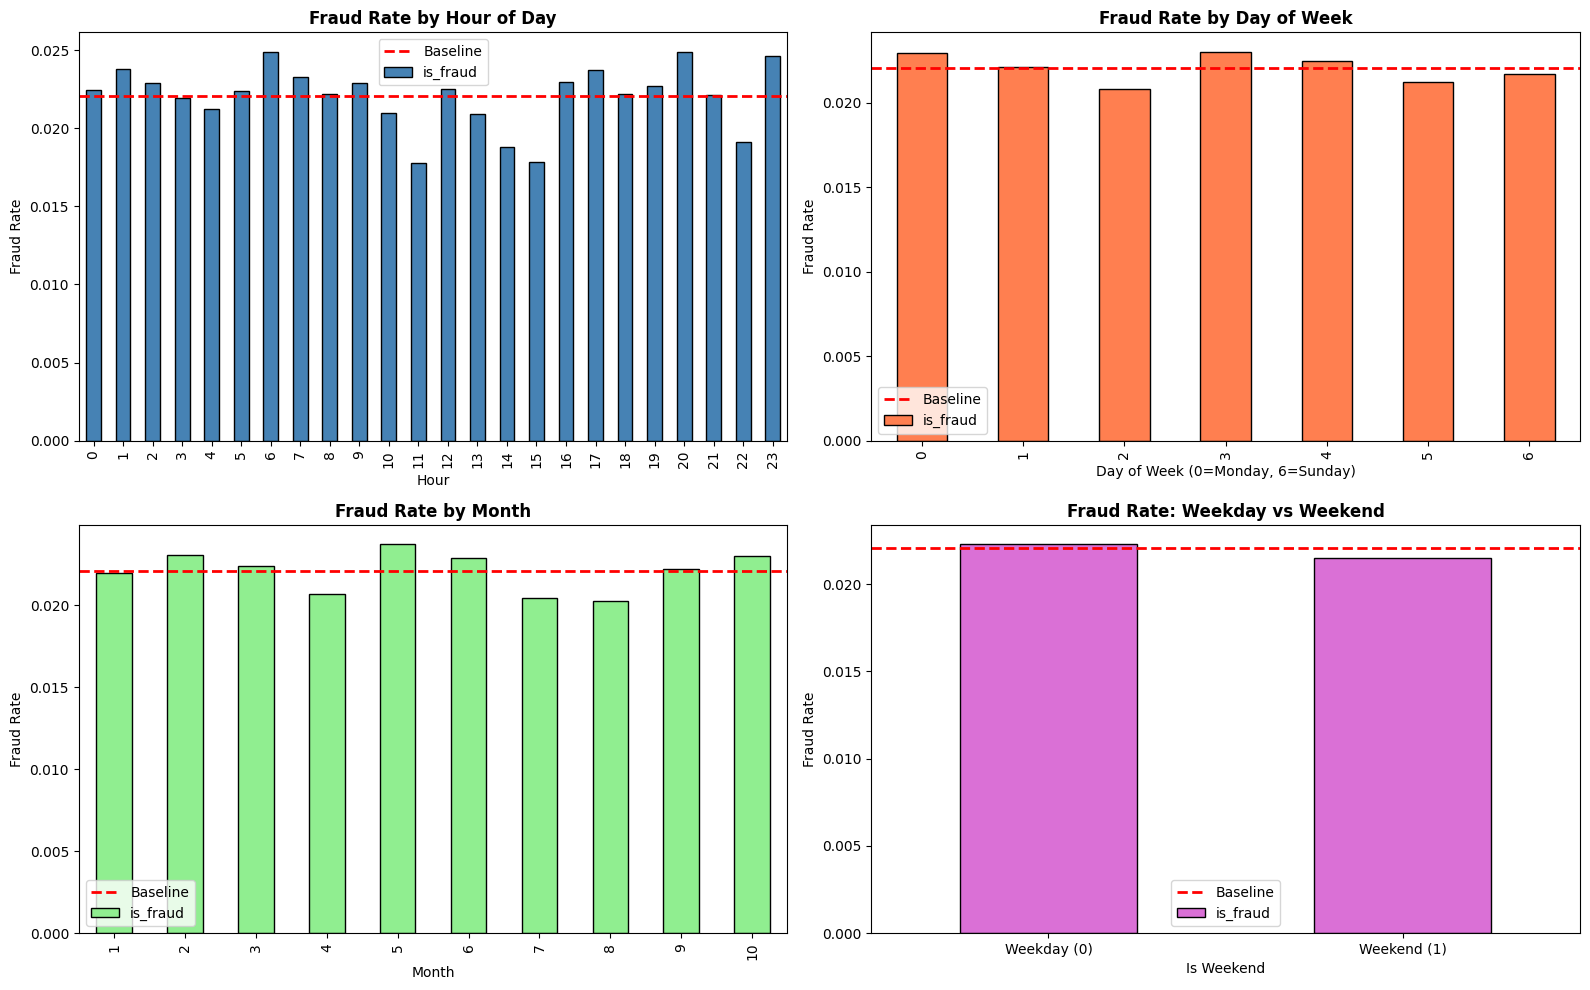


Temporal Insights:
- Peak fraud hour: 6 (fraud rate: 0.0249)
- Safest hour: 11 (fraud rate: 0.0178)
- Weekend fraud rate: 0.0215
- Weekday fraud rate: 0.0223


In [18]:
analyze_temporal_patterns(train_df, date_feature, target_col, baseline_fraud_rate)

### Categorical Features
#### Fraud Rates

In [19]:
analyze_categorical_fraud_rates(train_df, categorical_features, target_col)

Fraud Rates by Categorical Features

COUNTRY:
--------------------------------------------------------------------------------
country  fraud_count  total_count  fraud_rate
     TR          494        17967    2.749485
     PL          432        18094    2.387532
     RO          420        17660    2.378256
     ES          393        17333    2.267351
     US          441        19676    2.241309
     FR          394        18050    2.182825
     GB          394        18261    2.157604
     IT          367        17169    2.137574
     NL          345        18197    1.895917
     DE          287        17410    1.648478

BIN_COUNTRY:
--------------------------------------------------------------------------------
bin_country  fraud_count  total_count  fraud_rate
         TR          466        17973    2.592778
         PL          428        18033    2.373426
         ES          400        17401    2.298718
         RO          403        17687    2.278510
         FR          4

#### Visualize fraud rates for categorical features

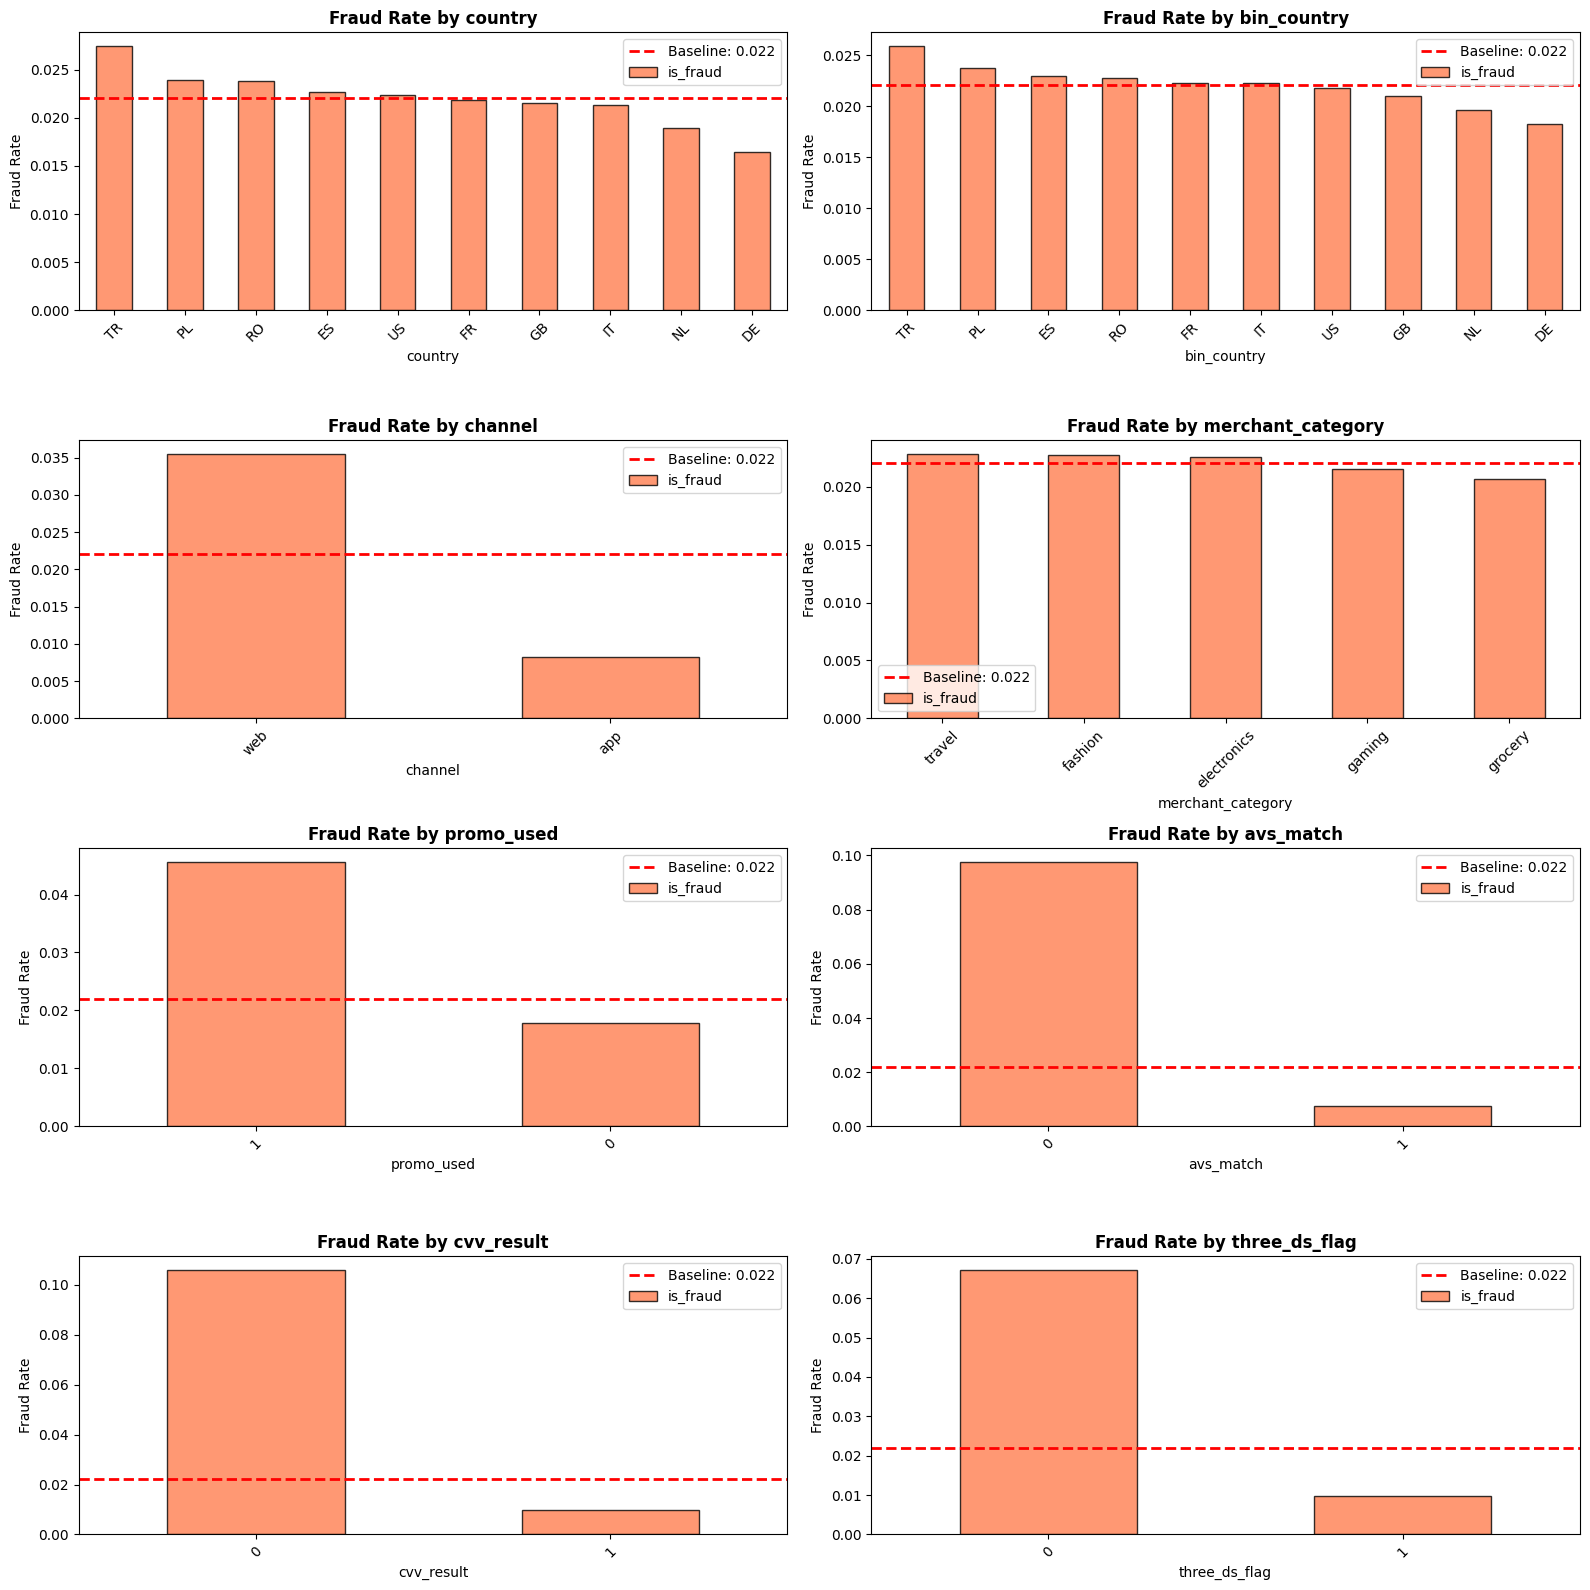


Visualization Insight:
- Categories significantly above the baseline (red line) are high-risk
- Large deviations suggest strong predictive power


In [20]:
plot_categorical_fraud_rates(train_df, categorical_features, target_col, baseline_fraud_rate)

#### Calculate mutual information scores for categorical features


Mutual Information Scores (Categorical Features):
          feature  mi_score
        avs_match  0.017262
       cvv_result  0.014880
    three_ds_flag  0.010097
          channel  0.004698
       promo_used  0.001906
          country  0.000180
      bin_country  0.000094
merchant_category  0.000017

Interpretation:
- Higher MI score = stronger association with target
- MI = 0 means no mutual dependence
- MI > 0.1 typically indicates meaningful predictive value


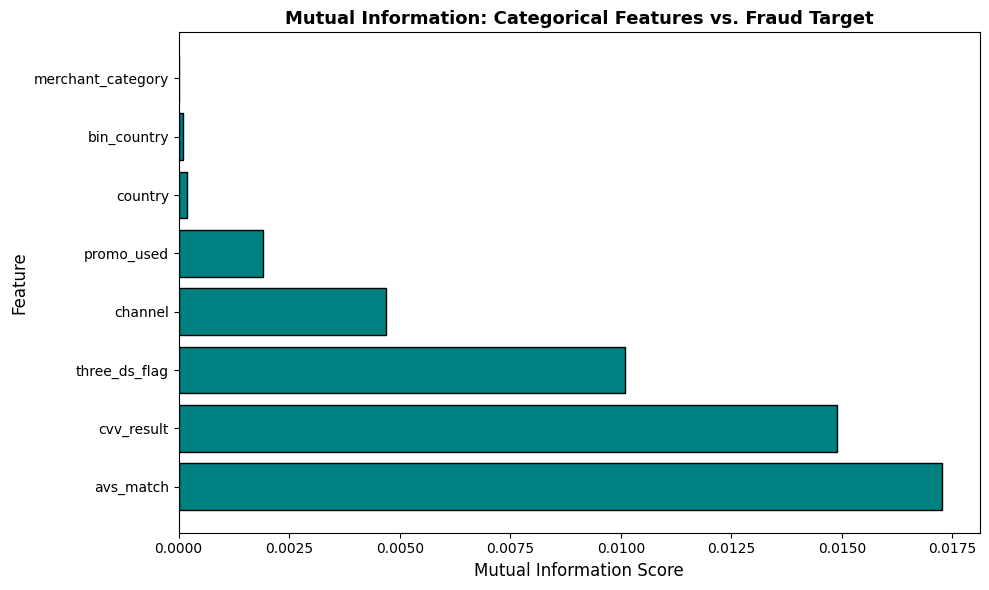

In [21]:
mi_df = analyze_mutual_information(train_df, categorical_features, target_col)

### Initial Feature Selection Recommendations

In [22]:
print_feature_recommendations(corr_df, mi_df, vif_df, numeric_features, categorical_features)

FEATURE SELECTION RECOMMENDATIONS

📊 SUMMARY OF EDA FINDINGS:
--------------------------------------------------------------------------------

1. NUMERIC FEATURES (Correlation Analysis):
   Features to KEEP (showing meaningful correlation):
   ✓ shipping_distance_km: 0.2684 correlation
   ✓ amount: 0.1992 correlation
   ✓ account_age_days: -0.1215 correlation
   ✓ total_transactions_user: -0.0130 correlation
   ✓ avg_amount_user: -0.0013 correlation

2. CATEGORICAL FEATURES (Mutual Information Analysis):
   Features to KEEP (MI > 0.01):
   ✓ avs_match: MI = 0.0173
   ✓ cvv_result: MI = 0.0149
   ✓ three_ds_flag: MI = 0.0101

3. MULTICOLLINEARITY CHECK:
   ✓ No severe multicollinearity detected

4. TEMPORAL PATTERNS:
   ✓ Hour of day shows fraud patterns (consider time-based features)
   ✓ Weekend/weekday distinction may be relevant

RECOMMENDED FEATURES FOR MODELING:

✅ NUMERIC FEATURES (all 5):
   • account_age_days
   • total_transactions_user
   • avg_amount_user
   • amount
   • s

## Feature Engineering

Apply feature engineering to create new predictive features. This includes:
- **Temporal features** (UTC and local timezone): hour, day_of_week, is_weekend, is_late_night, is_business_hours
- **Amount features**: amount_deviation, amount_vs_avg_ratio, micro/large transaction flags
- **User behavior**: transaction_velocity, new_account, high_frequency_user
- **Geographic**: country_mismatch, high_risk_distance, zero_distance
- **Security**: security_score, verification_failures, all_verifications_passed/failed

Local timezone conversion approximates transaction local time using the timezone of the user's country capital, enabling better detection of unusual-hour fraud patterns.

### Apply to training set

In [23]:
train_fe, train_new_features = engineer_features(train_df, date_col=date_feature, country_col='country')

FEATURE ENGINEERING

1. TIMEZONE CONVERSION:
Converting UTC to local time by country...
  ✓ Converted 179817 transactions to local time

2. TEMPORAL FEATURES (UTC):
  ✓ Created 6 UTC temporal features

3. TEMPORAL FEATURES (LOCAL TIME):
  ✓ Created 6 local time temporal features

4. TRANSACTION AMOUNT FEATURES:
  ✓ Created 4 amount-based features: ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']

5. USER BEHAVIOR FEATURES:
  ✓ Created 3 behavior features: ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']

6. GEOGRAPHIC FEATURES:
  ✓ Created 3 geographic features: ['country_mismatch', 'high_risk_distance', 'zero_distance']

7. SECURITY FEATURES:
  ✓ Created 4 security features: ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']

8. INTERACTION FEATURES (High-Risk Combinations):
  ✓ Created 6 interaction features: ['new_account_with_promo', 'late_night_micro_transaction', 'forei

### Apply to validation and test sets

In [24]:
val_fe, _ = engineer_features(val_df, date_col=date_feature, country_col='country')
test_fe, _ = engineer_features(test_df, date_col=date_feature, country_col='country')

FEATURE ENGINEERING

1. TIMEZONE CONVERSION:
Converting UTC to local time by country...
  ✓ Converted 59939 transactions to local time

2. TEMPORAL FEATURES (UTC):
  ✓ Created 6 UTC temporal features

3. TEMPORAL FEATURES (LOCAL TIME):
  ✓ Created 6 local time temporal features

4. TRANSACTION AMOUNT FEATURES:
  ✓ Created 4 amount-based features: ['amount_deviation', 'amount_vs_avg_ratio', 'is_micro_transaction', 'is_large_transaction']

5. USER BEHAVIOR FEATURES:
  ✓ Created 3 behavior features: ['transaction_velocity', 'is_new_account', 'is_high_frequency_user']

6. GEOGRAPHIC FEATURES:
  ✓ Created 3 geographic features: ['country_mismatch', 'high_risk_distance', 'zero_distance']

7. SECURITY FEATURES:
  ✓ Created 4 security features: ['security_score', 'verification_failures', 'all_verifications_passed', 'all_verifications_failed']

8. INTERACTION FEATURES (High-Risk Combinations):
  ✓ Created 6 interaction features: ['new_account_with_promo', 'late_night_micro_transaction', 'foreig

### Inspect engineered features

In [25]:
# Display new features created
print(f"New features created ({len(train_new_features)}):")
for i, feat in enumerate(train_new_features, 1):
    print(f"  {i:2d}. {feat}")

# Display sample rows with key engineered features
print("\n" + "=" * 80)
print("Sample of engineered features:")
print("=" * 80)
sample_features = ['transaction_time', 'country', 'hour', 'hour_local', 'is_late_night', 
                  'is_late_night_local', 'amount', 'amount_vs_avg_ratio', 
                  'country_mismatch', 'security_score', 'is_fraud']
display(train_fe[sample_features].head(10))

New features created (32):
   1. hour
   2. day_of_week
   3. month
   4. is_weekend
   5. is_late_night
   6. is_business_hours
   7. hour_local
   8. day_of_week_local
   9. month_local
  10. is_weekend_local
  11. is_late_night_local
  12. is_business_hours_local
  13. amount_deviation
  14. amount_vs_avg_ratio
  15. is_micro_transaction
  16. is_large_transaction
  17. transaction_velocity
  18. is_new_account
  19. is_high_frequency_user
  20. country_mismatch
  21. high_risk_distance
  22. zero_distance
  23. security_score
  24. verification_failures
  25. all_verifications_passed
  26. all_verifications_failed
  27. new_account_with_promo
  28. late_night_micro_transaction
  29. foreign_card_failed_verification
  30. new_high_velocity_account
  31. high_value_long_distance
  32. triple_risk_combo

Sample of engineered features:


,transaction_time,country,hour,hour_local,is_late_night,is_late_night_local,amount,amount_vs_avg_ratio,country_mismatch,security_score,is_fraud
0,2024-04-11 17:44:46+00:00,NL,17,19,0,0,192.52,2.210841,0,3,0
1,2024-07-16 04:57:17+00:00,PL,4,6,1,0,27.00,1.140203,1,3,0
2,2024-02-24 17:20:29+00:00,TR,17,20,0,0,142.58,1.210870,0,3,0
3,2024-04-21 17:41:47+00:00,GB,17,18,0,0,89.57,0.647697,0,3,0
4,2024-08-27 03:16:01+00:00,RO,3,6,1,0,56.47,0.679543,1,3,0
5,2024-10-27 04:19:10+00:00,NL,4,5,1,0,173.59,0.372223,0,3,0
6,2024-03-29 11:33:32+00:00,FR,11,12,0,0,17.71,0.396996,0,3,0
7,2024-08-31 07:44:00+00:00,US,7,3,0,1,45.66,1.136104,0,2,0
8,2024-06-22 21:50:37+00:00,RO,21,0,0,1,2962.22,63.079642,0,0,1
9,2024-08-27 10:41:26+00:00,NL,10,12,0,0,39.51,1.202740,0,3,0


## Final Feature Selection

In [26]:
final_features = analyze_final_feature_selection(train_new_features)

FINAL FEATURE SELECTION FOR MODELING

📊 AVAILABLE FEATURES:
--------------------------------------------------------------------------------
Original features: 13
  • Numeric: 5
  • Categorical: 8
Engineered features: 32
Total available: 45

🔍 FEATURE SELECTION ANALYSIS:
--------------------------------------------------------------------------------

1. ORIGINAL FEATURES:
   ✅ KEEP ALL NUMERIC (5):
      • shipping_distance_km - Strong correlation (0.27)
      • amount - Moderate correlation (0.20)
      • account_age_days - Negative correlation (-0.12)
      • total_transactions_user, avg_amount_user - Baseline info

   ✅ KEEP HIGH-VALUE CATEGORICAL (5 of 8):
      • avs_match - High MI (0.017), 9.8% fraud when failed
      • cvv_result - High MI (0.015), 10.6% fraud when failed
      • three_ds_flag - High MI (0.010), 6.7% fraud when disabled
      • channel - High signal (3.6% fraud on web vs 0.8% on app)
      • promo_used - High signal (4.6% fraud when used)

   ⚠️  EXCLUDE (3 of

### Store final feature lists for modeling

In [27]:
# Store final feature lists as variables for easy access in modeling
final_numeric_features = final_features['numeric']
final_categorical_features = final_features['categorical']
final_engineered_features = (
    final_features['temporal'] + 
    final_features['amount'] + 
    final_features['behavior'] + 
    final_features['geographic'] + 
    final_features['security'] + 
    final_features['interaction']
)
final_all_features = final_features['all_features']

print(f"Final feature count: {len(final_all_features)}")
print(f"  • Numeric: {len(final_numeric_features)}")
print(f"  • Categorical: {len(final_categorical_features)}")
print(f"  • Engineered: {len(final_engineered_features)}")

Final feature count: 30
  • Numeric: 5
  • Categorical: 5
  • Engineered: 20


## Save Feature Configuration

In [29]:
# Create and save feature configuration for deployment
# This config stores training-time statistics (quantile thresholds) needed for inference
from src.preprocessing import FeatureConfig

feature_config = FeatureConfig.from_training_data(train_fe)
feature_config.save("models/feature_config.json")

print("✓ Saved feature configuration for deployment:")
print(f"  • models/feature_config.json")
print(f"\nTraining-time statistics (for inference):")
print(f"  • Amount threshold (95th): ${feature_config.amount_95th_percentile:.2f}")
print(f"  • Transaction threshold (75th): {feature_config.total_transactions_75th_percentile:.0f} transactions")
print(f"  • Distance threshold (75th): {feature_config.shipping_distance_75th_percentile:.2f} km")
print(f"  • Timezone mappings: {len(feature_config.timezone_mapping)} countries")
print(f"  • Final features: {len(feature_config.final_features)} features")

✓ Saved feature configuration for deployment:
  • models/feature_config.json

Training-time statistics (for inference):
  • Amount threshold (95th): $595.97
  • Transaction threshold (75th): 56 transactions
  • Distance threshold (75th): 408.90 km
  • Timezone mappings: 10 countries
  • Final features: 30 features
